In [57]:
import osmnx as ox
import pandas as pd

In [58]:
AKL_df = pd.read_csv("./outputs/cleaned_property_data.csv",encoding='latin1')
AKL_df = AKL_df.drop(['Unnamed: 0'],axis=1)
print(AKL_df.head())
print(AKL_df.shape)

   CL_QPID  CL_Suburb  CL_Sale_Tenure  CL_Sale_Date  \
0    75499        232               0           229   
1    75639        263               0           119   
2    75639        263               0           169   
3    75639        263               0            70   
4    75639        263               0           162   

   CL_Land_Valuation_Capital_Value  CL_Building_Floor_Area  \
0                        -0.294735               -0.397669   
1                        -0.799770               -0.397669   
2                        -0.799770               -0.397669   
3                        -0.874988               -0.397669   
4                        -0.799770               -0.397669   

   CL_Building_Site_Cover  CL_Land_Area  CL_Bldg_Const  CL_Bldg_Cond  ...  \
0                 0.18143     15.111383             13             1  ...   
1                 0.18143     12.574967              3             1  ...   
2                 0.18143     12.574967              3           

In [59]:
street_nodes_df = pd.read_csv("./outputs/akl_street_nodes.csv")
street_nodes_df = street_nodes_df[street_nodes_df.columns[:4]]
print(street_nodes_df.head())

   street_id      source      target      street_name
0  984794487   279051892  2852049636  South Head Road
1  984794487  2852049636   279051893  South Head Road
2  984794487   279051903   279051892  South Head Road
3  984794487   279051893   279051895  South Head Road
4  984794487   279051895  7556143502  South Head Road


                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((222219.771 -4050395.343, 224043.539 ...  -35.698392  -37.364474   

    bbox_east   bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  175.903215  173.896328  298615087  relation  2094141 -36.541281  174.55061   

            display_name     class            type  importance  
0  Auckland, New Zealand  boundary  administrative        0.66  


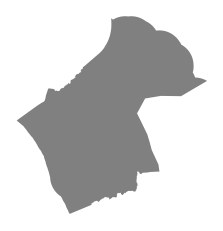

In [60]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [61]:
# Find Auckland BBox and download street informations
north, south, east, west = city_proj['bbox_north'][0],city_proj['bbox_south'][0],city_proj['bbox_east'][0],city_proj['bbox_west'][0]

highway_G = ox.graph_from_bbox(
    north,south,west,east,
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
projected_highway_G = ox.project_graph(highway_G)
print(projected_highway_G)

MultiDiGraph with 626825 nodes and 1284168 edges


In [62]:
def get_nearest_streets(property_df,road_G):
    nearest_edges = ox.distance.nearest_edges(road_G, property_df["CL_Longitude"].tolist(),property_df["CL_Latitude"].tolist(),return_dist=False)
    print(nearest_edges)
    return nearest_edges

In [63]:
nearest_edges = get_nearest_streets(AKL_df,projected_highway_G)
print(nearest_edges)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
def find_street_for_property(property_df):
    street_id_columns = []
    street_source_columns = []
    street_target_columns=[]
    for i in range(len(property_df)):
        u,v = nearest_edges[i][0],nearest_edges[i][1]
        #print("u={u},v={v}".format(u=u,v=v))
        street_node = street_nodes_df[street_nodes_df["source"] == u]
        street_node = street_node[street_node["target"] == v]
        #print("street_id={street_id}".format(street_id=street_id))
        street_id = street_node["street_id"].values[0]
        #print(street_id)
        street_id_columns.append(street_id)
        street_source_columns.append(u)
        street_target_columns.append(v)
        #break
    return street_id_columns,street_source_columns,street_target_columns

In [65]:
street_ids,street_sources,street_targets = find_street_for_property(AKL_df)
#print(street_ids,street_sources,street_targets)
AKL_df["street_id"] = street_ids
AKL_df["street_sources"] = street_sources
AKL_df["street_targets"] = street_targets
print(AKL_df.head())

   CL_QPID  CL_Suburb  CL_Sale_Tenure  CL_Sale_Date  \
0    75499        232               0           229   
1    75639        263               0           119   
2    75639        263               0           169   
3    75639        263               0            70   
4    75639        263               0           162   

   CL_Land_Valuation_Capital_Value  CL_Building_Floor_Area  \
0                        -0.294735               -0.397669   
1                        -0.799770               -0.397669   
2                        -0.799770               -0.397669   
3                        -0.874988               -0.397669   
4                        -0.799770               -0.397669   

   CL_Building_Site_Cover  CL_Land_Area  CL_Bldg_Const  CL_Bldg_Cond  ...  \
0                 0.18143     15.111383             13             1  ...   
1                 0.18143     12.574967              3             1  ...   
2                 0.18143     12.574967              3           

In [66]:
AKL_df = AKL_df.drop(["CL_Longitude","CL_Latitude"],axis=1)

In [67]:
AKL_df.to_csv("./outputs/property_data_with_street.csv")